## Least squares problems

In [1]:
# the required imports
import numpy as np
from scipy.linalg import solve_triangular
from numpy.linalg import qr, pinv, eig, norm, solve
import matplotlib.pyplot as plt
from skimage.transform import radon, rescale
from ipywidgets import interactive, fixed

_setup some helper functions_

In [2]:
# helper function to load Shepp-Logan phantom 
def getPhantom(size):
    if size == 128:
        return plt.imread('phantom.png')
    elif size == 32:
        p = plt.imread('phantom.png')
        return rescale(p, scale=1/4, mode='reflect', multichannel=False)
    elif size == 4:
        p = plt.imread('phantom.png')
        return rescale(p, scale=1/32, mode='reflect', multichannel=False)
    else:
        raise NotImplementedError


# compute the matrix of the Radon transform (and also do the right hand side)
def computeRadonMatrixRhs(image, numberOfAngles):
    angles = np.linspace(0, 180, numberOfAngles) 
    
    sizeX, sizeY = image.shape
    if sizeX != sizeY:                   # this works only for square images!
        raise ValueError
    size = image.size
    
    M = np.zeros((angles.size * sizeX, size)) # initialize matrix with zeros
    basisVec = np.zeros(size)            # initialize basis vector with zeros
    
    for i in range(size):
        basisVec[i] = 1                                # set to i-th basis vector
        bVecAsImg = basisVec.reshape(sizeX, sizeY)     # reshape to a 2d image
        
        column = radon(bVecAsImg, angles, circle=True) # compute Radon transform of this basis vector
        M[:, i] = column.flatten()                     # linearize and put into matrix as i-th column
        
        basisVec[i] = 0                                # reset basis vector to zero
        
    rhs = radon(image, angles, circle=True) # compute the right hand side
    return (M, rhs.flatten())

### setup our matrix (and right-hand side)

A has size =  (1024, 1024) , and b has size =  1024


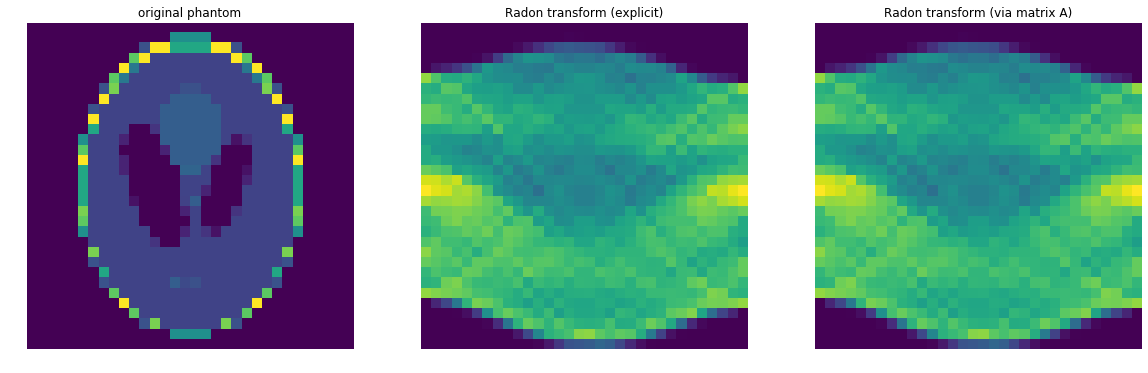

In [4]:
image = getPhantom(32)

plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1, title='original phantom')
plt.imshow(image); plt.axis('off')

A, b = computeRadonMatrixRhs(image, 32)
print("A has size = ", A.shape, ", and b has size = ", b.size)

plt.subplot(1, 3, 2, title='Radon transform (explicit)')
plt.imshow( b.reshape(32, 32) ); plt.axis('off')

plt.subplot(1, 3, 3, title='Radon transform (via matrix A)')
plt.imshow( A.dot(image.flatten()).reshape(32, 32) ); plt.axis('off')
plt.show()

### Pseudoinverse

In [5]:
# compute the pseudoinverse solution
solutionPinv = np.dot(pinv(A), b)

### Golub's method

In [6]:
# compute the solution via Golub's method
Q, R = qr(A)
solutionGolub = solve_triangular(R, np.dot(Q.T, b))

### Compare results

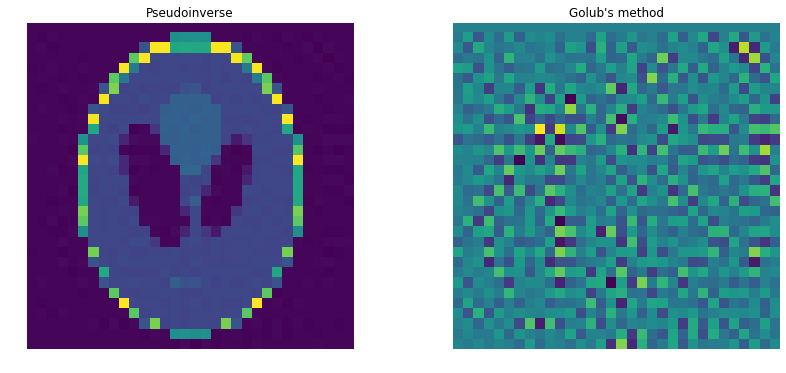

In [7]:
# compare the solutions using pseudoinverse and Golub
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1, title='Pseudoinverse'); plt.imshow(solutionPinv.reshape(32,32)); plt.axis('off')
plt.subplot(1, 2, 2, title='Golub\'s method'); plt.imshow(solutionGolub.reshape(32,32)); plt.axis('off')
plt.show()

### What happens when you add noise?

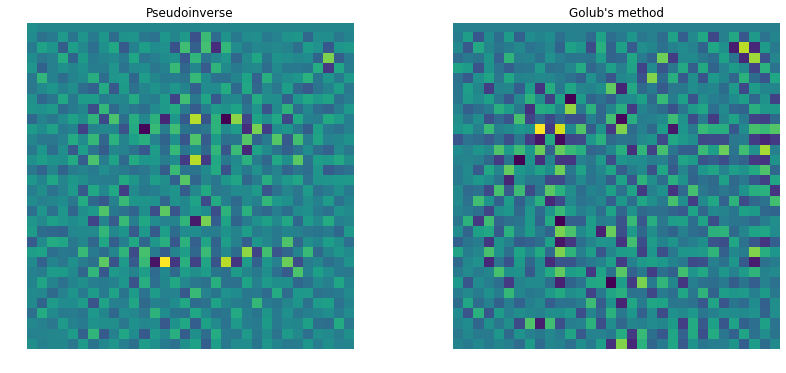

In [8]:
# add some white noise to right-hand-side b
noise = max(b) * 0.01 * np.random.randn(b.size)
bNoisy = b + noise

# compute the pseudoinverse solution
solutionPinvNoisy = np.dot(pinv(A), bNoisy)
# compute the Golub solution
solutionGolubNoisy = solve_triangular(R, np.dot(Q.T, bNoisy))

# compare the solutions
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1, title='Pseudoinverse'); plt.imshow(solutionPinvNoisy.reshape(32,32)); plt.axis('off')
plt.subplot(1, 2, 2, title='Golub\'s method'); plt.imshow(solutionGolubNoisy.reshape(32,32)); plt.axis('off')
plt.show()

## Eigenvalues and eigenvectors

In [9]:
# the QR algorithm
def qrAlgorithm(A, iterations):
    Qfinal = np.identity(A.shape[0])
    for k in range(iterations):
        Q, R = qr(A)
        A = R.dot(Q)
        Qfinal = Qfinal.dot(Q)
    
    return A, Qfinal

# a plotting function
def plotEig(matrix, axes):
    axes.plot(matrix, 'bo', markersize=1)
    axes.spines['left'].set_position('zero')
    axes.spines['bottom'].set_position('zero')
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)

### Compare QR algorithm with built-in function

In [10]:
# compute results of QR algorithm
Adiag, Q = qrAlgorithm(A, 200)

# compute results of built-in function
W, V = eig(A)

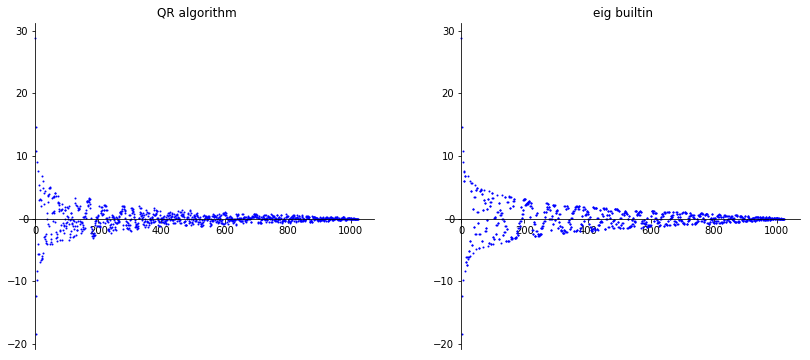

In [11]:
# show the results
plt.figure(figsize=(14,6));
axes1 = plt.subplot(1, 2, 1, title='QR algorithm'); plotEig(np.diagonal(Adiag), axes1)
axes2 = plt.subplot(1, 2, 2, title='eig builtin'); plotEig(np.real(W), axes2)
plt.show()